In [240]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score   
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from scipy.spatial.distance import pdist, squareform
from Bio import SeqIO
from scipy.cluster import hierarchy
import h5py
# vector graphics display (makes things less blurry)
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [241]:
###data directory
ddir = os.getcwd()

In [242]:
###reading the csv data file
df = pd.read_csv(os.path.join(ddir , "monomeric_long.csv"), delimiter='\t')
df

,slug,name,organism_label,division,organism_id,ex_max,em_max,pdb_0,seq_length,seq,...,lineage,scientific_name,superkingom,kindom,phylum,class,order,family,genus,species
0,bp02,BP02,synthetic construct,other sequences,32630,342,382,NaN,30,ELSKETALKKSFKFLVLIILWNNTVDAIHI,...,other entries;other sequences;artificial seque...,synthetic construct,k__other entries,K__other entries,p__other entries,c__other entries,o__other entries,f__other entries,g__other entries,s__synthetic construct
1,sirius,Sirius,Aequorea victoria,hydrozoans,6100,355,424,NaN,239,MVSKGEELFTGVVPILVELDGDVNGHRFSVSGEGEGDATYGKLTLK...,...,cellular organisms;Eukaryota;Opisthokonta;Meta...,Aequorea victoria,k__Eukaryota,K__Metazoa,p__Cnidaria,c__Hydrozoa,o__Leptothecata,f__Aequoreidae,g__Aequorea,s__Aequorea victoria
2,shbfp-n158sl173i,shBFP-N158S/L173I,Stichodactyla haddoni,sea anemones,475174,375,458,NaN,227,MAGLLKESMRIKMDMEGTVNGHYFKCEGEGDGNPFTGTQSMRIHVT...,...,cellular organisms;Eukaryota;Opisthokonta;Meta...,Stichodactyla haddoni,k__Eukaryota,K__Metazoa,p__Cnidaria,c__Anthozoa,o__Actiniaria,f__Stichodactylidae,g__Stichodactyla,s__Stichodactyla haddoni
3,ebfp12,EBFP1.2,Aequorea victoria,hydrozoans,6100,379,446,NaN,239,MVSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLK...,...,cellular organisms;Eukaryota;Opisthokonta;Meta...,Aequorea victoria,k__Eukaryota,K__Metazoa,p__Cnidaria,c__Hydrozoa,o__Leptothecata,f__Aequoreidae,g__Aequorea,s__Aequorea victoria
4,sbfp1,SBFP1,Aequorea victoria,hydrozoans,6100,380,446,NaN,239,MVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...,...,cellular organisms;Eukaryota;Opisthokonta;Meta...,Aequorea victoria,k__Eukaryota,K__Metazoa,p__Cnidaria,c__Hydrozoa,o__Leptothecata,f__Aequoreidae,g__Aequorea,s__Aequorea victoria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,mrhubarb719,SNIFP,Deinococcus radiodurans,bacteria,1299,697,720,NaN,320,MSRDPLPFFPPLYLGGPEITTENCEREPIHIPGSIQPHGALLTADG...,...,cellular organisms;Bacteria;Terrabacteria grou...,Deinococcus radiodurans,k__Bacteria,K__Bacteria,p__Deinococcota,c__Deinococci,o__Deinococcales,f__Deinococcaceae,g__Deinococcus,s__Deinococcus radiodurans
223,wi-phy,mRhubarb719,Rhodopseudomonas palustris,a-proteobacteria,1076,700,719,NaN,316,MAEGSVARQPDLLTCDDEPIHIPGAIQPHGLLLALAADMTIVAGSD...,...,cellular organisms;Bacteria;Pseudomonadota;Alp...,Rhodopseudomonas palustris,k__Bacteria,K__Bacteria,p__Pseudomonadota,c__Alphaproteobacteria,o__Hyphomicrobiales,f__Nitrobacteraceae,g__Rhodopseudomonas,s__Rhodopseudomonas palustris
224,mrhubarb720,Wi-Phy,Deinococcus radiodurans,bacteria,1299,701,719,3S7Q,335,MASMTGGQQMGRGSMSRDPLPFFPPLYLGGPEITTENCEREPIHIP...,...,cellular organisms;Bacteria;Terrabacteria grou...,Deinococcus radiodurans,k__Bacteria,K__Bacteria,p__Deinococcota,c__Deinococci,o__Deinococcales,f__Deinococcaceae,g__Deinococcus,s__Deinococcus radiodurans
225,mirfp720,mRhubarb720,Rhodopseudomonas palustris,a-proteobacteria,1076,701,720,NaN,316,MAEGSVARQPDLLTCDDEPIHIPGAIQPHGLLLALAADMTIVAGSD...,...,cellular organisms;Bacteria;Pseudomonadota;Alp...,Rhodopseudomonas palustris,k__Bacteria,K__Bacteria,p__Pseudomonadota,c__Alphaproteobacteria,o__Hyphomicrobiales,f__Nitrobacteraceae,g__Rhodopseudomonas,s__Rhodopseudomonas palustris


In [243]:
# array of amino acids in a certain protein ( sirius aequorea victoria row(1) )
aminoacids = set(df.seq[0])   ###sets the aminoacids variable to the 1 row of seq column
aminoacids.add('*')
aminoacids = np.array(list(aminoacids))   ###turns the 1 line of seq column into a python list
aminoacids.sort()
aminoacids # all amino acids plus termination

array(['*', 'A', 'D', 'E', 'F', 'H', 'I', 'K', 'L', 'N', 'S', 'T', 'V',
       'W'], dtype='<U1')

In [244]:
### generating matrices
#                      add termination char        left justify    split all chars  to numpy array
leftjustified_seqs = (df.seq.astype(str) + "*").str.ljust(512, " ").apply(list).apply(np.array)
# vertically concatenate all proteins
leftjustified_seqs = np.vstack(leftjustified_seqs)

###left_justified_seqs are fixed to the size of 512 with this function
leftjustified_seqs

array([['E', 'L', 'S', ..., ' ', ' ', ' '],
       ['M', 'V', 'S', ..., ' ', ' ', ' '],
       ['M', 'A', 'G', ..., ' ', ' ', ' '],
       ...,
       ['M', 'A', 'S', ..., ' ', ' ', ' '],
       ['M', 'A', 'E', ..., ' ', ' ', ' '],
       ['M', 'A', 'E', ..., ' ', ' ', ' ']], dtype='<U1')

In [245]:
leftjustified_seqs.shape
###227 proteins with 512 amino acid positions each

(227, 512)

In [246]:
def match_aminoacids(protein_sequence, chars=aminoacids):
    """
    compares each pair of amino-acid at position in protein against
    our library of amino-acids that are currently set to line 1 of the seq column of the dataframe
    (returns one hot)
    """
    return np.equal.outer(protein_sequence, chars).astype(np.float64)

match_aminoacids

<function __main__.match_aminoacids(protein_sequence, chars=array(['*', 'A', 'D', 'E', 'F', 'H', 'I', 'K', 'L', 'N', 'S', 'T', 'V',
       'W'], dtype='<U1'))>

In [247]:
##match_aminoacids(tmp)
tmp = match_aminoacids(leftjustified_seqs[1,])
tmp.shape

###output (512,14) means there are 512 amino acids and 14 types of it in the chosen row of aminocids which is currently 14

(512, 14)

In [248]:
protein_ohe = np.apply_along_axis(match_aminoacids, 1, leftjustified_seqs).reshape(leftjustified_seqs.shape[0], -1)

In [249]:
protein_ohe.shape

(227, 7168)

In [250]:
###Linear Regreesion Training

In [251]:
u, s, vt = np.linalg.svd(protein_ohe)
# matrix multiplication (this is just scaling each left singular vector, by it singular value) 
pc_coords = u @ np.diag(s)


In [252]:
# rows correspond to each protein in same order as 
pc_coords.shape



(227, 227)

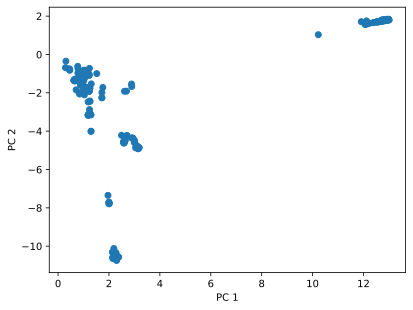

In [253]:
f, ax = plt.subplots()
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
plt.scatter(pc_coords[:,0], pc_coords[:,1]);
plt.draw()

In [254]:
X = pc_coords
y = (df["em_max"])

X.shape

(227, 227)

In [255]:
y.shape

(227,)

In [256]:
###training the model using train split method
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

##x is ohe proteins
##y is em_max


0.17391304347826086

In [257]:
###setting up the k-fold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf

KFold(n_splits=10, random_state=None, shuffle=False)

In [258]:
for train_index , test_index in kf.split(pc_coords):
      print(train_index ,test_index)

[ 23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  46  4

In [259]:
import numpy as np
from sklearn.model_selection import KFold

X = pc_coords
y = (df["em_max"])

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


TRAIN: [ 23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  1

In [260]:
from sklearn.model_selection import cross_validate
scoring = ['X_target', 'y']
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_validate(clf, X, y, scoring="r2")
scores

/home/laragokcelioglu/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'fit_time': array([0.06271935, 0.04448175, 0.05525804, 0.06045032, 0.05750799]),
 'score_time': array([0.01292872, 0.00788116, 0.01077366, 0.01080871, 0.00776792]),
 'test_score': array([0.47536893, 0.72435562, 0.75222891, 0.80409007, 0.2008555 ])}

In [269]:
###predictions
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
X = X_train[:227]
y = y_train[:227]
lasso = linear_model.Lasso()
y_pred = cross_val_predict(lasso, X, y, cv=3)
y_pred

array([562.88688034, 521.79424071, 605.24208368, 516.13254764,
       515.15422711, 514.99544084, 516.95491587, 515.40022294,
       514.72216795, 519.71234458, 613.58629719, 518.48576618,
       648.86623345, 519.48200994, 522.30154169, 602.30306757,
       625.7951094 , 607.33195586, 602.33153595, 527.81918394,
       510.65318869, 511.17566116, 510.7510984 , 508.93280979,
       510.39811863, 511.20882331, 512.23938064, 512.16163509,
       509.19181129, 513.69578137, 510.00068837, 513.06272258,
       510.3366233 , 511.46782481, 513.8669782 , 510.96841895,
       507.29296883, 511.07412751, 511.12720522, 578.44067336,
       580.6897069 , 510.17393533, 509.91493382, 602.39742501,
       650.69411138, 518.88896697, 516.8862456 , 510.07704661,
       583.03691167, 509.71886008, 509.71886008, 517.78946809,
       517.91753785, 603.43527491, 611.19115123, 629.16063599,
       510.72602845, 628.54551667, 594.92542937, 550.29884392,
       596.38945893, 594.87650526, 526.74625083, 503.66

Text(0.5, 1.0, 'Predictions Of em_max Using A Trained Model')

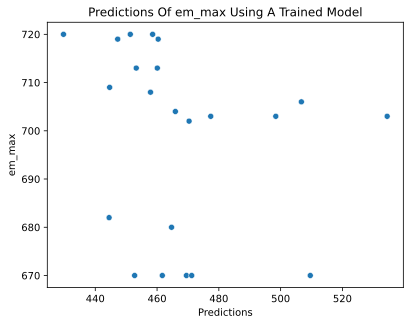

In [262]:
###predictions
from sklearn.model_selection import cross_val_predict

X = X_train[:22]
y = y_train[:22]
lasso = linear_model.Lasso()
y_pred = cross_val_predict(lasso, X, y, cv=5) 

sns.scatterplot(x=y_pred , y=y_test)
plt.xlabel("Predictions")
plt.ylabel("em_max")
plt.title("Predictions Of em_max Using A Trained Model")


In [263]:
from sklearn.metrics import mean_squared_error , mean_absolute_error
import math

###analytical analyis of the predictions vs real value
print("Mean Absolute Error: " , mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: " , mean_squared_error(y_test, y_pred))
print("RMSE: " , math.sqrt(mean_squared_error(y_test, y_pred)))



Mean Absolute Error:  231.07600980216196
Mean Squared Error:  54518.8612246055
RMSE:  233.4927434088809


Text(0.5, 1.0, 'Residual Distribution')

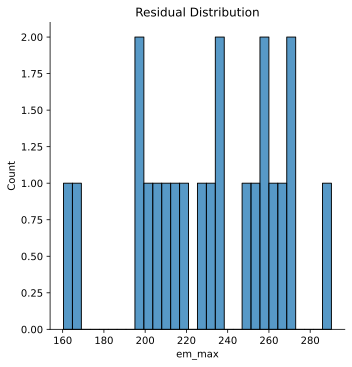

In [264]:
###residuals(errors)
residuals = y_test - y_pred
sns.displot(residuals, bins=30)
plt.title("Residual Distribution")

In [265]:
###checking for bias in residuals(errors)
import pylab
import scipy.stats as stats

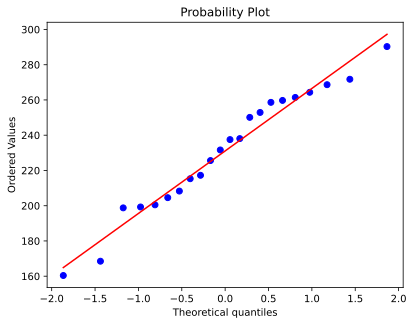

In [266]:
###plotting residuuals
stats.probplot(residuals , dist="norm", plot=pylab)
pylab.show()
